# Intro

After gathering this dataset, I spent a long time developing a multi-class artwork classification but found a tough time getting good enough accuracy for my own liking. This notebook develops a binary classification of the two art movements which had the most data available using pretrained modeling. The notebook can be improved significantly in many areas (developing better accuracy, multi-class classification, etc.) which I plan on doing in the future but this notebook is introductory to show off the dataset. Upvote if you like the work!

# Imports

In [1]:
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Loading Artworks

In [2]:
# Creating dataframe with art movement class weights
art_movements = pd.DataFrame()
art_movements['names'] = ['Renaissance', 'Romanticism']
art_movements['# of paintings'] = [6192, 6813]
art_movements = art_movements.sort_values(by=['# of paintings'], ascending=False)
art_movements = art_movements.reset_index(drop=True)
art_movements['class_weight'] = art_movements['# of paintings'].sum() / (art_movements.shape[0] * art_movements['# of paintings'])
class_weights = art_movements['class_weight'].to_dict()
print(class_weights)
art_movements_name = art_movements['names'].values
print(art_movements_name)

{0: 0.9544253632760898, 1: 1.0501453488372092}
['Romanticism' 'Renaissance']


In [3]:
# Loading artworks and splitting data for training and validation
batch_size = 64
train_input_shape = (256, 256, 3)

datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range= 5,
    zoom_range=0.05,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/wikiart-art-movementsstyles',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle =True,
    subset='training',
    seed=123,
    classes=art_movements_name.tolist()
)

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/wikiart-art-movementsstyles',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle =True,
    subset='validation',
    seed=123,
    classes=art_movements_name.tolist()
)

Found 11705 images belonging to 2 classes.
Found 1300 images belonging to 2 classes.


In [4]:
# Adding model steps
Step_Train = train_generator.n//train_generator.batch_size
Step_Validation = validation_generator.n//validation_generator.batch_size
print("Total number of batches =", Step_Train, "and", Step_Validation)

Total number of batches = 182 and 20


(64, 256, 256, 3)
Romanticism


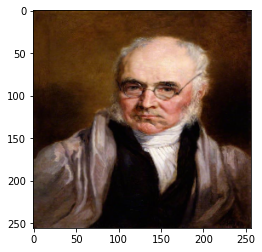

(64, 256, 256, 3)
Romanticism


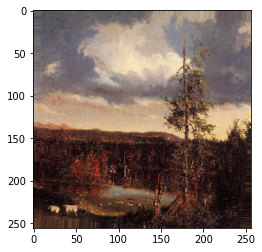

(64, 256, 256, 3)
Renaissance


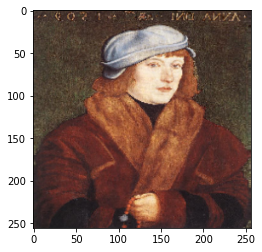

(64, 256, 256, 3)
Renaissance


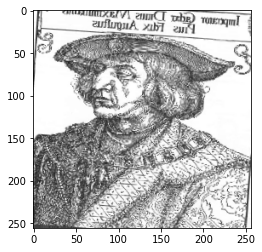

(64, 256, 256, 3)
Renaissance


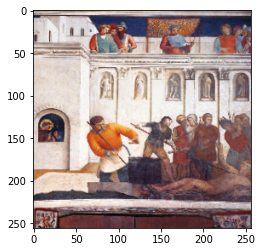

In [5]:
# Get the label to string mapping
label_to_str = {v: k for k, v in train_generator.class_indices.items()}

# Display some artworks
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape) 
    print(label_to_str[label[0]])
    plt.imshow(img[0])
    plt.show()

# Model Development

In [6]:
# Assign callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

In [7]:
# Load the Resnet50V2 pretrained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256,256,3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True

2023-01-14 00:09:12.538121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 00:09:12.717922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 00:09:12.718731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 00:09:12.720698: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


In [8]:
# Add extra layers to model
output = base_model.output

output = Flatten()(output)

output = Dense(256, kernel_initializer='he_uniform')(output)
output = Dropout(0.5)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(128, kernel_initializer='he_uniform')(output)
output = Dropout(0.25)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(64, kernel_initializer='he_uniform')(output)
output = Dropout(0.25)(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(32, kernel_initializer='he_uniform')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)

output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=base_model.inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
# Compile the model with a learning rate schedule
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer= adam, metrics=['accuracy'])

# Model Training and Retraining

In [10]:
# Initial model fit
model.fit(train_generator, 
             validation_data=validation_generator,
             steps_per_epoch=Step_Train, 
             validation_steps=Step_Validation,
             epochs=30,
             shuffle=True,
             verbose=1,
             callbacks=[reduce_lr, early_stop],
             class_weight=class_weights
             )

2023-01-14 00:09:20.838258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-14 00:09:30.644124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 66/182 [=========>....................] - ETA: 7:23 - loss: 0.5904 - accuracy: 0.6784

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


182/182 [==============================] - 801s 4s/step - loss: 0.4836 - accuracy: 0.7700 - val_loss: 0.4131 - val_accuracy: 0.8023
Epoch 2/30
182/182 [==============================] - 643s 4s/step - loss: 0.3006 - accuracy: 0.8932 - val_loss: 0.4005 - val_accuracy: 0.8180
Epoch 3/30
182/182 [==============================] - 655s 4s/step - loss: 0.2049 - accuracy: 0.9349 - val_loss: 0.3770 - val_accuracy: 0.8344
Epoch 4/30
182/182 [==============================] - 645s 4s/step - loss: 0.1466 - accuracy: 0.9603 - val_loss: 0.3618 - val_accuracy: 0.8484
Epoch 5/30
182/182 [==============================] - 635s 3s/step - loss: 0.1213 - accuracy: 0.9675 - val_loss: 0.4187 - val_accuracy: 0.8328
Epoch 6/30
182/182 [==============================] - 633s 3s/step - loss: 0.0995 - accuracy: 0.9747 - val_loss: 0.3914 - val_accuracy: 0.8414
Epoch 7/30
182/182 [==============================] - 636s 3s/step - loss: 0.0825 - accuracy: 0.9778 - val_loss: 0.3685 - val_accuracy: 0.8633
Epoch 8/30

In [11]:
# Freeze core ResNet layers
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

In [12]:
# Retraining
model.fit(train_generator, 
             validation_data=validation_generator,
             steps_per_epoch=Step_Train, 
             validation_steps=Step_Validation,
             epochs=20,
             shuffle=True,
             verbose=1,
             callbacks=[reduce_lr, early_stop],
             class_weight=class_weights
             )

Epoch 1/20
182/182 [==============================] - 634s 3s/step - loss: 0.0157 - accuracy: 0.9999 - val_loss: 0.3877 - val_accuracy: 0.8805
Epoch 2/20
182/182 [==============================] - 629s 3s/step - loss: 0.0160 - accuracy: 0.9999 - val_loss: 0.3796 - val_accuracy: 0.8805
Epoch 3/20
182/182 [==============================] - 626s 3s/step - loss: 0.0160 - accuracy: 0.9997 - val_loss: 0.3812 - val_accuracy: 0.8813
Epoch 4/20
182/182 [==============================] - 625s 3s/step - loss: 0.0159 - accuracy: 0.9999 - val_loss: 0.3671 - val_accuracy: 0.8844
Epoch 5/20
182/182 [==============================] - 630s 3s/step - loss: 0.0161 - accuracy: 0.9998 - val_loss: 0.3829 - val_accuracy: 0.8813
Epoch 6/20
182/182 [==============================] - 632s 3s/step - loss: 0.0156 - accuracy: 0.9998 - val_loss: 0.3806 - val_accuracy: 0.8773
Epoch 7/20
182/182 [==============================] - 632s 3s/step - loss: 0.0156 - accuracy: 0.9998 - val_loss: 0.3807 - val_accuracy: 0.8828